# More uncertainty tests

Import test data and SHAP models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import pickle

from dataclasses import dataclass
from xgboost import XGBClassifier

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
import stroke_utilities.process_data as process_data
import stroke_utilities.models as models
import stroke_utilities.scenario as scenario

## Set up paths and filenames

In [3]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './stroke_utilities/data/'
    output_folder = './stroke_utilities/output/'
    model_folder = './stroke_utilities/models'
    model_text = 'lgbm_decision_'
    notebook: str = '01_'

paths = Paths()

## Load data

Import the data from file:

In [4]:
# Load data
train = pd.read_csv(paths.data_read_path + 'cohort_10000_train.csv')
train['stroke_team_id'] = train['stroke_team_id'].astype('category')
test = pd.read_csv(paths.data_read_path + 'cohort_10000_test.csv')
test['stroke_team_id'] = test['stroke_team_id'].astype('category')

## Process data

Restrict the data to the following ten features, plus the "thrombolysis" feature.

In [5]:
# Put data into the format for model
features_to_model = [
    'stroke_team_id',
    'stroke_severity',
    'prior_disability',
    'age',
    'infarction',
    'onset_to_arrival_time',
    'precise_onset_known',
    'onset_during_sleep',
    'arrival_to_scan_time',
    'afib_anticoagulant',
    # 'year',    
    'thrombolysis'
]

In [6]:
train = train[features_to_model]
test = test[features_to_model]

In [7]:
stroke_team_ids = train.sort_values('stroke_team_id')['stroke_team_id'].unique().to_list()

Split the data. X contains the features for the model to use to predict use of thrombolysis, and y contains whether thrombolysis was used in the real data.

In [8]:
X_train, y_train = process_data.split_X_and_y(train, 'thrombolysis')
X_test, y_test = process_data.split_X_and_y(test, 'thrombolysis')

Check the list of features currently included in the X data:

In [9]:
features = list(X_train)

features

['stroke_team_id',
 'stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant']

For the XGBoost model, we need to change the single "stroke team ID" column to many individual team columns. For 119 separate teams, we will create 119 new columns. Each column may contain either 1 (meaning "yes") where a patient attended that stroke team, or 0 (meaning "no") where the patient did not attend that stroke team.

In [10]:
X_train = process_data.one_hot_encode_column(
    X_train, 'stroke_team_id', prefix='team')

X_test = process_data.one_hot_encode_column(
    X_test, 'stroke_team_id', prefix='team')

Check that the "stroke_team_id" column has gone and that there are now many "team_" columns.

In [11]:
# Get features
features_ohe = list(X_train)

# Print the first several...
print(features_ohe[:15])
# ... and last few feature names:
print(features_ohe[-3:])
# The remaining features are all "team_X" for increasing X.

['stroke_severity', 'prior_disability', 'age', 'infarction', 'onset_to_arrival_time', 'precise_onset_known', 'onset_during_sleep', 'arrival_to_scan_time', 'afib_anticoagulant', 'team_1', 'team_2', 'team_3', 'team_4', 'team_5', 'team_6']
['team_117', 'team_118', 'team_119']


## Get SHAP values

In [12]:
filename = f'{paths.model_folder}/shap_explainer_probability.p'
print(filename)
with open(filename, 'rb') as filehandler:
    explainer_probability = pickle.load(filehandler)

./stroke_utilities/models/shap_explainer_probability.p


In [13]:
with open(f'{paths.model_folder}/shap_explainer.p', 'rb') as fp:
    explainer = pickle.load(fp)

In [14]:
with open(f'{paths.model_folder}/shap_explainer_probability.p', 'rb') as fp:
    explainer_prob = pickle.load(fp)

In [15]:
shap_values = explainer.shap_values(X_test)
shap_values_prob = explainer_prob.shap_values(X_test)

 96%|=================== | 9553/10000 [00:11<00:00]       

## Inspect

In [16]:
shap_values

array([[ 2.3055479e-01,  3.5574859e-01, -6.7545269e-03, ...,
         3.8993263e-04, -1.1375784e-02,  5.0967374e-06],
       [-2.0256398e+00, -6.7803931e-01, -2.4915010e-01, ...,
         3.0105938e-03, -2.8919824e-03,  1.1325357e-05],
       [ 9.7793740e-01,  5.8927941e-01,  1.2059644e-01, ...,
        -4.4980794e-01, -8.4807687e-03, -2.2852901e-05],
       ...,
       [-2.3980770e+00,  2.5701925e-01, -3.7745178e-01, ...,
         4.0751356e-03, -1.2559432e-03,  5.0967374e-06],
       [-1.6628511e+00,  3.3319637e-01, -7.3512173e-01, ...,
         2.8692193e-03, -5.0547002e-03, -1.6677929e-03],
       [ 5.5671889e-01,  4.4737101e-01, -1.9050105e-02, ...,
         4.1675437e-03, -5.1599587e-03,  5.0967374e-06]], dtype=float32)

In [17]:
shap_values_prob

array([[ 0.03878865,  0.03708629, -0.00346092, ...,  0.        ,
         0.        ,  0.        ],
       [-0.33897354, -0.11947999, -0.04790886, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19960814,  0.05960853,  0.01364045, ..., -0.07823933,
         0.        ,  0.        ],
       ...,
       [-0.21098816,  0.0119806 , -0.03363617, ...,  0.        ,
         0.        ,  0.        ],
       [-0.18398179,  0.02120744, -0.07219641, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0925869 ,  0.04534363, -0.0171921 , ...,  0.        ,
         0.        ,  0.        ]])

In [18]:
shap_values_sum = np.sum(shap_values, axis=1)#.shape
shap_values_prob_sum = np.sum(shap_values_prob, axis=1)#.shape

In [19]:
from scipy.special import expit

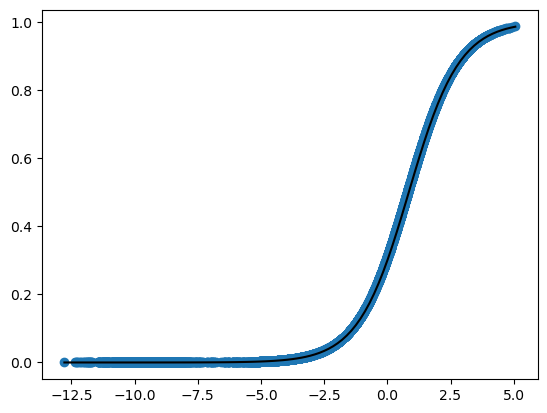

In [21]:
y_offset = -np.min(shap_values_prob_sum)
x_offset = -0.85  # eyeballed

x = np.linspace(np.min(shap_values_sum), np.max(shap_values_sum), 100)
y_model = expit(x + x_offset) #- y_offset

plt.scatter(shap_values_sum, shap_values_prob_sum + y_offset)
plt.plot(x, y_model, color='k')

In [22]:
y_offset

0.3926216513057263

In [23]:
expit(-0.040156 + x_offset)

0.29107763555923205